In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import json
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
info_data_path = "../data/raw_data/data.info"
with open(info_data_path, 'r') as f:
    info = f.read().splitlines()

info_list = [info[i].split(",") for i in range(len(info))]
info_df = pd.DataFrame(info_list[1:]) 
info_df.columns = info_list[0]

In [3]:
info_df["transcript_position"] = info_df["transcript_position"].astype(str).astype(int)

In [4]:
Hct116_rep3_run1 = pd.read_csv("../data/aws_predictions/Hct116_rep3_run1_prediction.csv")
Hct116_rep3_run4 = pd.read_csv("../data/aws_predictions/Hct116_rep3_run4_prediction.csv")
Hct116_rep4_run3 = pd.read_csv("../data/aws_predictions/hct116_rep4_run3_prediction.csv")

In [5]:
Hct116_rep3_run1["label"] = Hct116_rep3_run1.score.map(lambda x:1 if x>=0.35 else 0)
Hct116_rep3_run4["label"] = Hct116_rep3_run4.score.map(lambda x:1 if x>=0.35 else 0)
Hct116_rep4_run3["label"] = Hct116_rep4_run3.score.map(lambda x:1 if x>=0.35 else 0)

In [6]:
test_Hct116_rep3_run1 = Hct116_rep3_run1.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])
test_Hct116_rep3_run4 = Hct116_rep3_run4.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])
test_Hct116_rep4_run3 = Hct116_rep4_run3.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])

In [15]:
test_Hct116_rep3_run1.head()

,transcript,position,score,label_x,gene_id,transcript_id,transcript_position,label_y
0,ENST00000373020,1006,0.009091,0,ENSG00000000003,ENST00000373020,1006,0
1,ENST00000373020,1013,0.018182,0,ENSG00000000003,ENST00000373020,1013,0
2,ENST00000373020,1149,0.013636,0,ENSG00000000003,ENST00000373020,1149,0
3,ENST00000373020,512,0.018182,0,ENSG00000000003,ENST00000373020,512,0
4,ENST00000373020,689,0.009091,0,ENSG00000000003,ENST00000373020,689,0


In [18]:
merge1 = Hct116_rep3_run1.merge(Hct116_rep3_run4, on = ['transcript','position'],how='inner')
merge2 = merge1.merge(Hct116_rep4_run3, on = ['transcript','position'],how='inner')

In [19]:
merge2.head()

,transcript,position,score_x,label_x,score_y,label_y,score,label
0,ENST00000373020,1006,0.009091,0,0.036364,0,0.022727,0
1,ENST00000373020,1013,0.018182,0,0.004545,0,0.004545,0
2,ENST00000373020,1149,0.013636,0,0.000000,0,0.000000,0
3,ENST00000373020,512,0.018182,0,0.022727,0,0.022727,0
4,ENST00000373020,689,0.009091,0,0.009091,0,0.018182,0


In [33]:
merge2['new_xy'] = np.where((merge2['label_x'] == merge2['label_y']), True, False)

In [34]:
merge2['new_xz'] = np.where((merge2['label_x'] == merge2['label']), True, False)

In [35]:
merge2['new_yz'] = np.where((merge2['label_y'] == merge2['label']), True, False)

In [36]:
merge2.head()

,transcript,position,score_x,label_x,score_y,label_y,score,label,new_xy,new_xz,new_yz
0,ENST00000373020,1006,0.009091,0,0.036364,0,0.022727,0,True,True,True
1,ENST00000373020,1013,0.018182,0,0.004545,0,0.004545,0,True,True,True
2,ENST00000373020,1149,0.013636,0,0.000000,0,0.000000,0,True,True,True
3,ENST00000373020,512,0.018182,0,0.022727,0,0.022727,0,True,True,True
4,ENST00000373020,689,0.009091,0,0.009091,0,0.018182,0,True,True,True


In [46]:
merge2 = merge2.rename({'label':'label_z'},axis=1)
merge2 = merge2.rename({'score':'score_z'},axis=1)

In [47]:
merge2.head()

,transcript,position,score_x,label_x,score_y,label_y,score_z,label_z,new_xy,new_xz,new_yz
0,ENST00000373020,1006,0.009091,0,0.036364,0,0.022727,0,True,True,True
1,ENST00000373020,1013,0.018182,0,0.004545,0,0.004545,0,True,True,True
2,ENST00000373020,1149,0.013636,0,0.000000,0,0.000000,0,True,True,True
3,ENST00000373020,512,0.018182,0,0.022727,0,0.022727,0,True,True,True
4,ENST00000373020,689,0.009091,0,0.009091,0,0.018182,0,True,True,True


In [48]:
merged_d0 = merge2.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])
merged_d0 = merged_d0.drop(["transcript_id", "transcript_position"], axis = 1)
merged_d0.label= merged_d0.label.astype(int)

In [44]:
merged_d0.head()

,transcript,position,score_x,label_x,score_y,label_y,score,label_z,new_xy,new_xz,new_yz,gene_id,label
0,ENST00000373020,1006,0.009091,0,0.036364,0,0.022727,0,True,True,True,ENSG00000000003,0
1,ENST00000373020,1013,0.018182,0,0.004545,0,0.004545,0,True,True,True,ENSG00000000003,0
2,ENST00000373020,1149,0.013636,0,0.000000,0,0.000000,0,True,True,True,ENSG00000000003,0
3,ENST00000373020,512,0.018182,0,0.022727,0,0.022727,0,True,True,True,ENSG00000000003,0
4,ENST00000373020,689,0.009091,0,0.009091,0,0.018182,0,True,True,True,ENSG00000000003,0


In [49]:
merged_d0['x_actual'] = np.where((merged_d0['label_x'] == merged_d0['label']), True, False)
merged_d0['y_actual'] = np.where((merged_d0['label_y'] == merged_d0['label']), True, False)
merged_d0['z_actual'] = np.where((merged_d0['label_z'] == merged_d0['label']), True, False)

In [50]:
merged_d0['mean_scores'] = merged_d0[['score_x', 'score_y','score_z']].mean(axis=1)
merged_d0["pred_mean"] = merged_d0.mean_scores.map(lambda x:1 if x>=0.35 else 0)

In [51]:
merged_d0['mean_actual'] = np.where((merged_d0['pred_mean'] == merged_d0['label']), True, False)

In [52]:
merged_d0.head()

,transcript,position,score_x,label_x,score_y,label_y,score_z,label_z,new_xy,new_xz,new_yz,gene_id,label,x_actual,y_actual,z_actual,mean_scores,pred_mean,mean_actual
0,ENST00000373020,1006,0.009091,0,0.036364,0,0.022727,0,True,True,True,ENSG00000000003,0,True,True,True,0.022727,0,True
1,ENST00000373020,1013,0.018182,0,0.004545,0,0.004545,0,True,True,True,ENSG00000000003,0,True,True,True,0.009091,0,True
2,ENST00000373020,1149,0.013636,0,0.000000,0,0.000000,0,True,True,True,ENSG00000000003,0,True,True,True,0.004545,0,True
3,ENST00000373020,512,0.018182,0,0.022727,0,0.022727,0,True,True,True,ENSG00000000003,0,True,True,True,0.021212,0,True
4,ENST00000373020,689,0.009091,0,0.009091,0,0.018182,0,True,True,True,ENSG00000000003,0,True,True,True,0.012121,0,True


In [60]:
ind = ind = ["rep3_run1", "rep3_run4", "rep4_run3","mean"]
rep3_run1_count = list(merged_d0["x_actual"].value_counts())
rep3_run4_count = list(merged_d0["y_actual"].value_counts())
rep4_run3_count = list(merged_d0["z_actual"].value_counts())
mean_count = list(merged_d0["mean_actual"].value_counts())

In [61]:
df = pd.DataFrame([rep3_run1_count[0], rep3_run4_count[0], rep4_run3_count[0],mean_count[0]], columns = ["True"], index = ind)
df["False"] = [rep3_run1_count[1], rep3_run4_count[1], rep4_run3_count[1], mean_count[1]]
df = df.transpose()

Text(0.5, 1.0, 'Hct116 Cancer Cell Line')

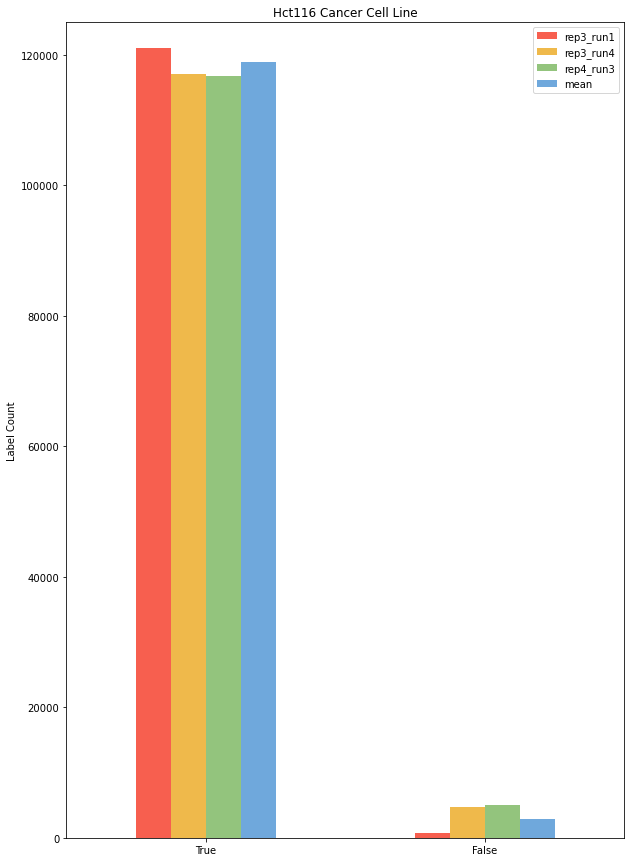

In [62]:
from turtle import width

colour_scheme = {"rep3_run1": "#f75f4f", "rep3_run4": "#efb94b", "rep4_run3": "#93c47d", "mean": "#6fa8dc"}
df.plot(kind = "bar", figsize = (10, 15), color = colour_scheme)

plt.ylabel("Label Count")
plt.ylim([0, 125000])
plt.gca().xaxis.set_tick_params(rotation = 0)
plt.title("Hct116 Cancer Cell Line")